In [1]:
import jax
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

import time
import traceback

print(f"Found {num_devices} JAX devices of type {device_type}.")
# assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 1 JAX devices of type NVIDIA L4.


In [2]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

# from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline
# from diffusers import EulerAncestralDiscreteScheduler

In [3]:
# pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     # revision="fp16",
#     dtype=jnp.float16,
#     from_pt=True,
# )

pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    revision="bf16",
    dtype=jnp.bfloat16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/home/hzchen/miniconda3/envs/tf/lib/python3.10/site-packages/diffusers/configuration_utils.py:219: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /home/hzchen/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/eb5fd1048921a4f94e627038e4107dfe7c68aca2/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_

In [ ]:
# pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)

In [12]:
batch_size_list = [2 ** x for x in range(0, 8)]
steps = 50
cfg_scale = 15.0
# prompt = "postapocalyptic steampunk city, exploration, cinematic, realistic, hyper detailed, photorealistic maximum detail, volumetric light, (((focus))), wide-angle, (((brightly lit))), (((vegetation))), lightning, vines, destruction, devastation, wartorn, ruins"
prompt = "detailed portrait beautiful Neon Operator Girl, cyberpunk futuristic neon, reflective puffy coat, decorated with traditional Japanese ornaments by Ismail inceoglu dragan bibin hans thoma greg rutkowski Alexandros Pyromallis Nekro Rene Maritte Illustrated, Perfect face, fine details, realistic shaded, fine-face, pretty face"
negative_prompt = "(((blurry))), ((foggy)), (((dark))), ((monochrome)), sun, (((depth of field)))"

In [5]:
def create_key(seed=0):
    return jax.random.PRNGKey(seed)

rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

In [20]:
# pre_warm
batch_size = 1
_prompt = [prompt] * batch_size
prompt_ids = pipeline.prepare_inputs(_prompt)

_neg_prompt = [negative_prompt] * batch_size
neg_prompt_ids = pipeline.prepare_inputs(_neg_prompt)

p_params = replicate(params)
prompt_ids = shard(prompt_ids)

neg_prompt_ids = shard(neg_prompt_ids)

t0 = time.time()
images = pipeline(
    prompt_ids=prompt_ids,
    neg_prompt_ids=neg_prompt_ids,
    num_inference_steps=50,
    guidance_scale=cfg_scale,
    height=512,
    width=512,
    jit=True,
    params=p_params,
    prng_seed=rng,
)[0]
t1 = time.time()
its = steps * batch_size / (t1 - t0)
print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))

batch_size 1, it/s: 9.02, time: 5.54


In [17]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

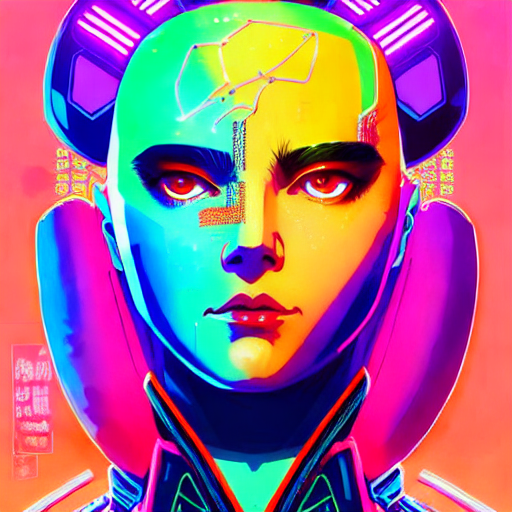

In [18]:
images = images.reshape((images.shape[0],) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)
image_grid(images, 1, 1)

In [ ]:
result = []
batch_size_list = [1,1,2,2,4,4,8,8]
for batch_size in batch_size_list:
    try:
        rng = jax.random.PRNGKey(0)
        rng = jax.random.split(rng, num_devices)
        
        _prompt = [prompt] * batch_size
        prompt_ids = pipeline.prepare_inputs(_prompt)

        _neg_prompt = [negative_prompt] * batch_size
        neg_prompt_ids = pipeline.prepare_inputs(_neg_prompt)

        p_params = replicate(params)
        prompt_ids = shard(prompt_ids)

        neg_prompt_ids = shard(neg_prompt_ids)

        # print(prompt_ids.shape)
        # print(neg_prompt_ids.shape)

        t0 = time.time()
        images = pipeline(
            prompt_ids=prompt_ids,
            neg_prompt_ids=neg_prompt_ids,
            num_inference_steps=50,
            guidance_scale=cfg_scale,
            height=512,
            width=512,
            jit=True,
            params=p_params,
            prng_seed=rng,
        )[0]
        t1 = time.time()
        its = steps * batch_size / (t1 - t0)
        print("batch_size {}, it/s: {}, time: {}".format(batch_size, round(its, 2), round((t1 - t0), 2)))
    except Exception:
        print(traceback.print_exc())
        print("batch_size {}, OOM".format(batch_size))
        its = 0
    result.append(round(its, 2))
result_jit = result[1::2]
result_jit